# Homework
1. Program the solution of unconstraint minimization for $T=80$. How many variables we need to solve the problem? 

In [1]:
using Optim, Parameters, Plots, BenchmarkTools

In [2]:
function sol(a, c)
    @unpack T = p 
    a = copy(a)
    c = copy(c)
    return (a=a, c=c)
end

sol (generic function with 1 method)

In [3]:
function params(; β = 0.96,
    R = 1.04,
    ybar = 100,
    ā = 150, 
    T = 3)

    y = ones(T) * ybar
    a = zeros(T+1)
    a[1] = ā
    c = zeros(T)
    ut = zeros(T)
    return (β=β, R=R, ā=ā, y=y, a=a, c=c, ut=ut, T=T)
end 

# Función de utilidad, asumiendo utilidad CRRA
function u(c; γ=2.0)
    return c^(1 - γ) / (1 - γ)
end

function ct(p, a)
    @unpack R, y, T, c = p
    for t in 1:T
        c[t] = R * a[t] + y[t] - a[t+1]
    end    
end

# Función objetivo
function objective(p, x)
    @unpack β, R, ā, y, a, ut, T = p
    a[2:end-1] = x
    for t in 1:T
        c = R * a[t] + y[t] - a[t+1]
        ut[t] =  β^(t-1) * u(c)
    end

    return -(sum(ut))  # Negativo porque Optim minimiza por defecto
end

p = params(T=20)
a0 = ones(p.T-1)*p.ā
objective(p, a0) #Test function works
result = optimize(x -> objective(p,x), a0, BFGS())
# t1 = @belapsed optimize(x -> objective(p,x), a0, BFGS())
@btime optimize(x -> objective(p,x), a0, BFGS())
#Optimal values
p.a[2:end-1] = Optim.minimizer(result)
ct(p, p.a)

#Save optimal values
s1 = sol(p.a, p.c)

  3.877 ms (41426 allocations: 700.20 KiB)


(a = [150.0, 144.23241422391735, 138.31945198524994, 132.26273188617563, 126.05144125280435, 119.68087117844591, 113.14856461339753, 106.44280141584684, 99.55807163792126, 92.483042262975  …  77.74938089792148, 70.0700768949841, 62.17384519551627, 54.05548003461116, 45.69585502927444, 37.08849442958186, 28.225260911836635, 19.09608236477371, 9.69115180222087, 0.0], c = [111.76758577608265, 111.6822588076241, 111.58949817848432, 111.5017999088183, 111.41262772447062, 111.31954141218623, 111.2317057820866, 111.14244183455948, 111.0573522404631, 110.96552809351084, 110.87612839646103, 110.78927923885423, 110.6990347752672, 110.60531896872578, 110.52184420672117, 110.43519480086357, 110.34677329492848, 110.2581889835364, 110.16877385714379, 110.0787978743097])

2. Program the solution of constraint minimization for $T=80$. How many equations, variables and constraint we need? 


In [4]:
using JuMP, Ipopt

# Parámetros
β = 0.96  # Factor de descuento
R = 1.04  # Tasa de retorno de los activos
T = 20  # Número de periodos
y = ones(T) * 100  # Ingresos en cada periodo
ā = 150  # Activo inicial

# Utilidad
function u(c; γ=2.0)
    return c^(1 - γ) / (1 - γ)
end

# Modelo de optimización
model = Model(Ipopt.Optimizer)

@variable(model, c[1:T] >= 0)  # Consumo no negativo en cada periodo
@variable(model, a[1:T+1])  # Activos en cada periodo

# Función objetivo dinámica
@NLobjective(model, Max, sum(β^(t-1) * u(c[t]) for t in 1:T))

# Restricciones de activos y consumo
@constraint(model, a[1] == ā)
@constraint(model, [t in 1:T], a[t+1] == R * a[t] + y[t] - c[t])
@constraint(model, a[T+1] == 0)  # Valor terminal de activos debe ser cero

# Resolver el modelo
# t2 = @belapsed optimize!(model)
@time optimize!(model)
# Resultados
println("El consumo óptimo en cada periodo es: ", value.(c))
println("Los activos en cada periodo son: ", value.(a))

s2 = sol(value.(a), value.(c))

┌ Warning: Function u automatically registered with 1 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :u, 1, u; autodiff = true)
│ ```
└ @ MathOptInterface.Nonlinear C:\Users\felix\.julia\packages\MathOptInterface\2rAFb\src\Nonlinear\operators.jl:430



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:       62
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       20

Total number of variables............................:       41
                     variables with only lower bounds:       20
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       22
Total number of inequality c

[111.74102527249518, 111.65475824925456, 111.56812513752047, 111.4817377512917, 111.3957411164428, 111.31015771146222, 111.22496384817293, 111.14011808316093, 111.05557012880317, 110.97125931745249, 110.88710574680863, 110.80299520953389, 110.71875853950215, 110.63414633834434, 110.54880084265254, 110.46222768804294, 110.37377122752122, 110.28259755778711, 110.18768923978044, 110.08785475045654]
Los activos en cada periodo son: [150.0, 144.25897472750484, 138.37457546735047, 132.34143334852402, 126.15335293117326, 119.80374593197737, 113.28573805779426, 106.5922037319331, 99.7157737980495, 92.6488346211683, 85.38352868856255, 77.91176408929643, 70.22523944333439, 62.31549048156561, 54.17396376248391, 45.79212147033073, 37.161578641101, 28.274270559223822, 19.12264382380566, 9.699860336977451, 0.0]


(a = [150.0, 144.25897472750484, 138.37457546735047, 132.34143334852402, 126.15335293117326, 119.80374593197737, 113.28573805779426, 106.5922037319331, 99.7157737980495, 92.6488346211683  …  77.91176408929643, 70.22523944333439, 62.31549048156561, 54.17396376248391, 45.79212147033073, 37.161578641101, 28.274270559223822, 19.12264382380566, 9.699860336977451, 0.0], c = [111.74102527249518, 111.65475824925456, 111.56812513752047, 111.4817377512917, 111.3957411164428, 111.31015771146222, 111.22496384817293, 111.14011808316093, 111.05557012880317, 110.97125931745249, 110.88710574680863, 110.80299520953389, 110.71875853950215, 110.63414633834434, 110.54880084265254, 110.46222768804294, 110.37377122752122, 110.28259755778711, 110.18768923978044, 110.08785475045654])

3. Program the solution of Euler equation system solving by $c_t$ for $T=80$. How many equations and variables we need?


In [5]:
using NLsolve

function params(; β = 0.96,
    R = 1.04,
    ybar = 100,
    ā = 150, 
    T = 3)

    y = ones(T) * ybar
    a = zeros(T+1)
    a[1] = ā
    c = zeros(T)
    ut = zeros(T)
    return (β=β, R=R, ā=ā, y=y, a=a, c=c, ut=ut, T=T, ybar=ybar)
end 

function u_prime(c; γ=2.0)
    return c^(-γ)
end


function at(p, c)
    @unpack R, y, T, a = p
    for t in 1:T
        a[t+1] = R * a[t] + y[t] - c[t]
    end    
end

# Objective function
function objective!(p, F, x)
    @unpack β, R, y, a, T = p
    #c = x
    # F = similar(x)
    for t in 1:T-1
        F[t] = u_prime(x[t]) - β * R * u_prime(x[t+1])
        a[t+1] = R * a[t] + y[t] - x[t]
    end
    a[end] = R * a[end-1] + y[end] - x[end]
    F[end] = a[end]
    return F
end

function objective(p, x)
    objective!(p, similar(x), x)
end


p = params(T=20)
c0 = ones(p.T)*p.ā
F = similar(c0)
# t3 = @belapsed  result = nlsolve(x-> objective(p, x), c0)  
@btime result = nlsolve(x-> objective(p, x), c0)
result = nlsolve(x-> objective(p, x), c0)
#Save optimal values
at(p,result.zero)
s3 = sol(p.a, result.zero)

  29.400 μs (169 allocations: 47.66 KiB)


(a = [150.0, 144.23555051478684, 138.32823943706774, 132.27249521962017, 126.06252651104462, 119.6923133819572, 113.15559820039104, 106.44587614210994, 99.55638532148609, 92.48009652757449  …  77.73760707604652, 70.05591314834581, 62.156411154633815, 54.03056634184877, 45.669505828899645, 37.06400510036376, 28.204473959904803, 19.080941921893597, 9.683043018643076, 7.270273272297345e-11], c = [111.76444948521315, 111.67673309831059, 111.5888737949303, 111.50086851736036, 111.4127141895292, 111.32440771684446, 111.23594598629674, 111.14732586630825, 111.05854420677105, 110.96959783898622, 110.88048357563238, 110.79119821074258, 110.70173851964583, 110.61210125897038, 110.52228316662308, 110.43228096169186, 110.3420913444735, 110.2517109964074, 110.16113658012627, 110.07036473931609])

4. Program the solution of Euler equation system solving by $a_t$ for $T=80$. How many equations and variables we need?


In [6]:
using NLsolve

function params(; β = 0.96,
    R = 1.04,
    ybar = 100,
    ā = 150, 
    T = 3)

    y = ones(T) * ybar
    a = zeros(T+1)
    a[1] = ā
    c = zeros(T)
    ut = zeros(T)
    return (β=β, R=R, ā=ā, y=y, a=a, c=c, ut=ut, T=T, ybar=ybar)
end 

function u_prime(c; γ=2.0)
    return c^(-γ)
end


function ct(p, a)
    @unpack R, y, T, c = p
    for t in 1:T
        c[t] = R * a[t] + y[t] - a[t+1]
    end    
end

# Objective function
function objective!(p, F, x)
    @unpack β, R, y, a, T = p
    #c = x
    # F = similar(x)
    a[2:end-1] = x
    for t in 1:T-1
        F[t] = u_prime(R * a[t] + y[t] - a[t+1]) - β * R * u_prime(R * a[t+1] + y[t] - a[t+2])
    end
    return F
end

function objective(p, x)
    objective!(p, similar(x), x)
end


p = params(T=20)
a0 = ones(p.T-1)*p.ā
@btime result = nlsolve(x-> objective(p, x), a0)  #Punto para solución smart con autodiff = :forward
result = nlsolve(x-> objective(p, x), a0)
# #Save optimal values
p.a[2:end-1] = result.zero
ct(p, p.a)
s4 = sol(p.a, p.c)

  50.000 μs (276 allocations: 74.34 KiB)


(a = [150.0, 144.23168874338236, 138.32209547987583, 132.2654973401775, 126.05594259756356, 119.68724151347638, 113.1529568170187, 106.44639380361403, 99.56059003761308, 92.48830464300798  …  77.75386599068013, 70.07573629484183, 62.17914751932434, 54.05529033967634, 45.69500311526088, 37.08875779656072, 28.226645268782228, 19.098360115888678, 9.69320901939797, 0.0], c = [111.76831125661764, 111.67886081324184, 111.58948195889337, 111.50017463622103, 111.41093878798972, 111.32177435699676, 111.23268128608541, 111.14365951814551, 111.05470899610961, 110.9658296629586, 110.87702146172036, 110.78828433546549, 110.69961822731116, 110.61102308042098, 110.52249883800252, 110.4340454433106, 110.34566283964094, 110.25735096364483, 110.16908550112626, 110.08093738017389])

5. Program the solution using bisection method (we review using Solow) for $T=80$. Explain the implementation. 

6. Plot the solution of (1), (2), (3), (4 )and (5) for $c_t$ and $a_t$ in a subplot.  

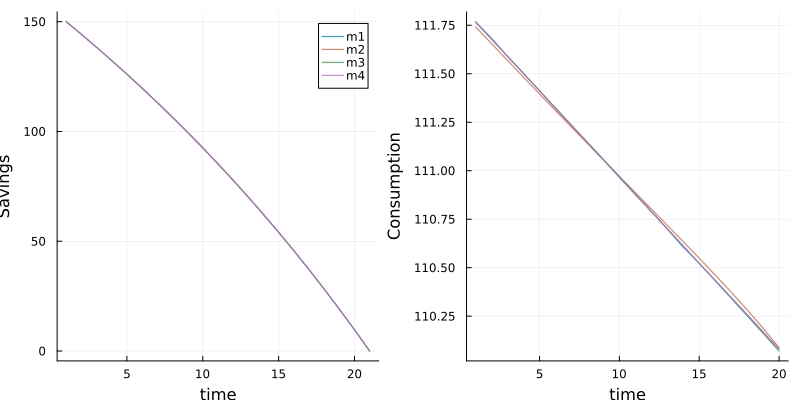

In [7]:
p1 = plot(s1.a, label="m1", xlabel="time", ylabel="Savings")
p1 = plot!(s2.a, label="m2")
p1 = plot!(s3.a, label="m3")
p1 = plot!(s4.a, label="m4")

p2 = plot(s1.c,  label="", xlabel="time", ylabel="Consumption")
p2 = plot!(s2.c, label="")
p2 = plot!(s3.c, label="")
p2 = plot!(s4.c, label="")

plot(p1,p2, size=(800, 400))

7. Plot the time of solution by T and by method. 

In [8]:
function params(; β = 0.96,
    R = 1.04,
    ybar = 100,
    ā = 150, 
    T = 3)

    y = ones(T) * ybar
    a = zeros(T+1)
    a[1] = ā
    c = zeros(T)
    ut = zeros(T)
    return (β=β, R=R, ā=ā, y=y, a=a, c=c, ut=ut, T=T)
end 

# Función de utilidad, asumiendo utilidad CRRA
function u(c; γ=2.0)
    return c^(1 - γ) / (1 - γ)
end

function ct(p, a)
    @unpack R, y, T, c = p
    for t in 1:T
        c[t] = R * a[t] + y[t] - a[t+1]
    end    
end

# Función objetivo
function objective(p, x)
    @unpack β, R, ā, y, a, ut, T = p
    a[2:end-1] = x
    for t in 1:T
        c = R * a[t] + y[t] - a[t+1]
        ut[t] =  β^(t-1) * u(c)
    end

    return -(sum(ut))  # Negativo porque Optim minimiza por defecto
end

function time_solution(T)
    p = params(T=T)
    a0 = ones(p.T-1)*p.ā
    # objective(p, a0) #Test function works
    t1 = @belapsed optimize(x -> objective(p,x), a0, BFGS())
    return t1
end

T=20 
tvec = zeros(T)
for t in 1:T
    tvec[t] = time_solution(t)
end

plot(1:T, tvec)


8. Analize the role of $\gamma$ in the utility function. How change utility, the dynamics of $c_t$ and $a_t$ for different $\gamma$ values. Analize theoretically and graphically.   
$$u(c) = \frac{c^{1-\gamma}}{1-\gamma}$$ 

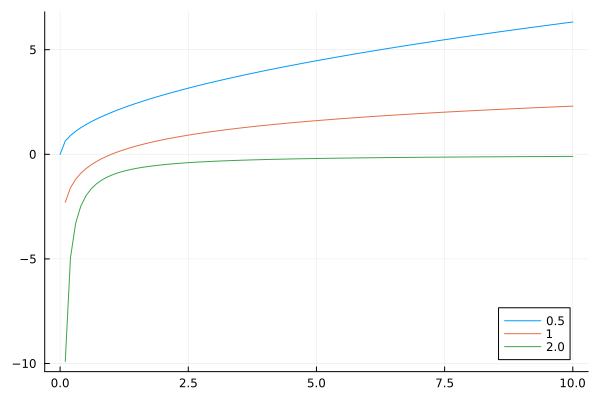

In [69]:
function params(; β = 0.96,
    R = 1.04,
    ybar = 100,
    ā = 150, 
    T = 3, 
    γ=2.0)

    y = ones(T) * ybar
    a = zeros(T+1)
    a[1] = ā
    c = zeros(T)
    ut = zeros(T)
    return (β=β, R=R, ā=ā, y=y, a=a, c=c, ut=ut, T=T, γ=γ)
end 

function u(p, c; γ=2.0)
    # @unpack γ = p
    if γ ==1 
        return log.(c)
    else
        return c.^(1 - γ) ./ (1 - γ) 
    end
end

c = range(0, 10, 100)

plot(c, u(p,c; γ=.5), label="0.5")
plot!(c, u(p,c; γ=1.0), label="1")
plot!(c, u(p,c; γ=2.0), label="2.0")

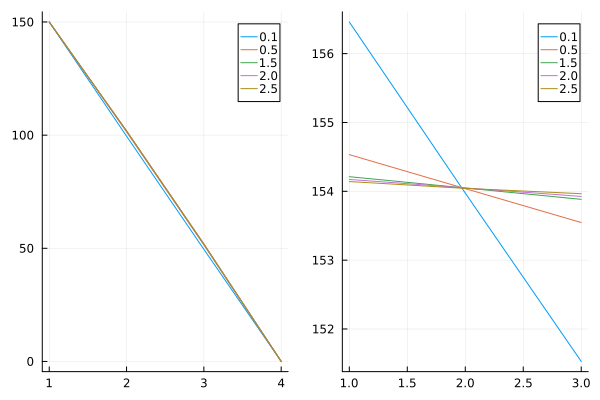

In [52]:
function params(; β = 0.96,
    R = 1.04,
    ybar = 100,
    ā = 150, 
    T = 3, 
    γ=2.0)

    y = ones(T) * ybar
    a = zeros(T+1)
    a[1] = ā
    c = zeros(T)
    ut = zeros(T)
    return (β=β, R=R, ā=ā, y=y, a=a, c=c, ut=ut, T=T, γ=γ)
end 

#Función de utilidad, asumiendo utilidad CRRA
function u(p, c)
    @unpack γ = p
    if γ ==1 
        return log(c)
    else
        return c > 0 ? c^(1 - γ) / (1 - γ) : -Inf
    end
end

function ct(p, a)
    @unpack R, y, T, c = p
    for t in 1:T
        c[t] = R * a[t] + y[t] - a[t+1]
    end    
end

#Función objetivo
function objective(p, x)
    @unpack β, R, ā, y, a, ut, T = p
    a[2:end-1] = x
    for t in 1:T
        c = R * a[t] + y[t] - a[t+1]
        ut[t] =  β^(t-1) * u(p, c)
    end

    return -(sum(ut))  # Negativo porque Optim minimiza por defecto
end

function gamma_solution(γ)
    p = params(γ=γ)
    a0 = ones(p.T-1)*p.ā
    # objective(p, a0) #Test function works
    result = optimize(x -> objective(p,x), a0, BFGS())
    p.a[2:end-1] = Optim.minimizer(result)
    ct(p, p.a)
    
    #Save optimal values
    res = sol(p.a, p.c)    
    return res
end

N = 5
γvec = [0.1, 0.5, 1.5, 2, 2.5] ##range(0.1, 0.5, N)
a_vec = Dict() #llave=iterador, valor=a 
c_vec = Dict() #llave=iterador, valor=c

for (i, γ) in enumerate(γvec)
    s = gamma_solution(γ)
    a_vec[i] = s.a 
    c_vec[i] = s.c
end

p1 = plot(a_vec[1], label=γvec[1])
for i in 2:N
    p1 = plot!(a_vec[i], label=γvec[i])
end

p2 = plot(c_vec[1], label=γvec[1])
for i in 2:N
    p2 = plot!(c_vec[i], label=γvec[i])
end
plot(p1,p2)

In [46]:
a_vec[1]

4-element Vector{Float64}:
 150.0
  99.53992495634334
  49.54685743944488
   0.0

9. Present the Lagrangean, and the FOC and the Euler equations for the consumption-saving model. 

10. Using your fast method from 1-5, solve the consumption-saving model using a CARA utility function $u(c)=\frac{1-e^{ac}}{a}$ for $a\neq 0$. Plot the solution for $c_t$ and $a_t$ and compare with the solution of the CRRA utility. 